<a href="https://colab.research.google.com/github/hlmth/statsapp/blob/master/ConcatBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.9 MB/s eta 0:00:00


In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import os
import copy
import pandas as pd
from transformers import AutoTokenizer, AutoModel, BertModel
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)


PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116
cuda:0


In [4]:
num_epochs = 1

batch_size = 8

# Chargement du tokenizer et du modèle BERT
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
import torch
from PIL import Image

class MyDataset(torch.utils.data.Dataset):
  'Caractérise un jeu de données pour PyTorch'
  def __init__(self, transforms = None, root_dir = '/content/drive/MyDrive/data', mode = 'train', tokenizer = tokenizer):
        'Initialisation'
        self.df = pd.read_json(f"{root_dir}/{mode}.jsonl", lines=True)
        self.labels = self.df.label
        self.image_names = self.df.img
        self.transforms = transforms
        self.root_dir = root_dir
        self.tokenizer = tokenizer
#        print(len(self.labels[self.labels == 0])/len(self.labels))
      
  def __len__(self):
        "Représente le nombre total d'exemples du jeu de données"
        return len(self.labels)

  def __getitem__(self, idx):
      'Génère un exemple à partir du jeu de données'
      # Sélection de l'exemple
      if torch.is_tensor(idx):
            idx = idx.tolist()
      item = self.df.iloc[idx]


      text = item['text']

      encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )


      image_path = f"{self.root_dir}/{self.image_names.iloc[idx]}"

      img = Image.open(image_path, ).convert('RGB')

      if self.transforms :
            img = self.transforms(img)

      return encoding['input_ids'].flatten(), encoding['attention_mask'].flatten(), img, self.labels.iloc[idx]
  


In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'dev': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: MyDataset(transforms = data_transforms[x], mode = x) for x in ['train', 'dev']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'dev']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
image_datasets

{'train': <__main__.MyDataset at 0x7fb6a2da7d90>,
 'dev': <__main__.MyDataset at 0x7fb6a2da7880>}

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else :
        for param in model.parameters():
            param.requires_grad = True

def initialize_model( feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    model_ft = models.resnet18(pretrained=use_pretrained)
    
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 1)
    set_parameter_requires_grad(model_ft, feature_extract)
    return model_ft

In [9]:
# définir le modèle Bert
bert_model = BertModel.from_pretrained('bert-base-uncased')
set_parameter_requires_grad(bert_model, feature_extracting= True )

# définir le modèle ResNet18
resnet18_model = initialize_model( feature_extract= True )
resnet18_model.load_state_dict(torch.load('/content/drive/MyDrive/data/best_model.pth'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be remove

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [22]:
class ConcatBertModel(torch.nn.Module):
    def __init__(self, bert_model, resnet18_model):
        super(ConcatBertModel, self).__init__()
        self.bert_model = bert_model
        self.resnet18_model = resnet18_model
        self.fc = torch.nn.Linear(768 + 512, 1)
        
    def forward(self, input_ids, attention_mask, segment, image):
        bert_output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=segment)[1]
        resnet_output = self.resnet18_model(image)
        resnet_output = torch.flatten(resnet_output, start_dim=1)
        concat_output = torch.cat((bert_output, resnet_output), dim=1)
        output = self.fc(concat_output)
        output = torch.sigmoid(output)
        return output

In [24]:
# initialiser une instance de FusionModel
concat_bert = ConcatBertModel(bert_model, resnet18_model)
concat_bert = concat_bert.to(device)
print(concat_bert)

ConcatBertModel(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [25]:
def train_concat_bert(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for input_ids, attention_masks, inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                input_ids = input_ids.to(device)
                attention_masks = attention_masks.to(device)
                labels = labels.to(device)
              
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # effectuer la prédiction et calculer la perte
                    outputs = concat_bert(input_ids, attention_masks, inputs)
                    loss = criterion(outputs, labels.float().unsqueeze(1).to(device))
                
                    if phase == 'train':
                        # rétropropager et mettre à jour les poids
                        loss.backward()
                        optimizer.step()
                    preds = (outputs > 0.5).float()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
                # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return concat_bert, val_acc_history

In [26]:
# définir la fonction de perte et l'optimiseur
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(concat_bert.parameters(), lr=0.001)

In [27]:
print("Params to learn:")
params_to_update = []
for name,param in concat_bert.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [28]:
fusion_model, hist = train_concat_bert(concat_bert, dataloaders_dict, criterion, optimizer, num_epochs)

Epoch 0/0
----------


  0%|          | 0/1063 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/1063 [00:49<?, ?it/s]


TypeError: ignored

In [ ]:
path = '/content/drive/MyDrive/data/img'

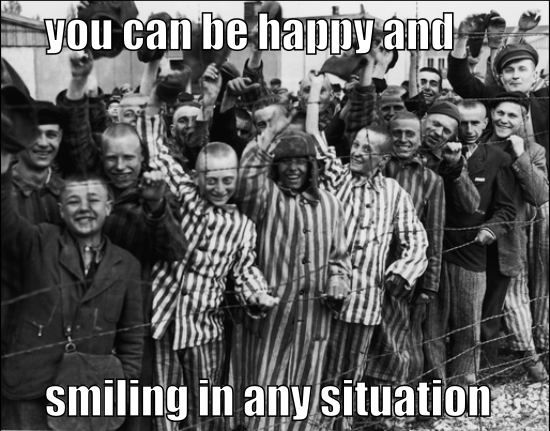

In [ ]:
root_dir = '/content/drive/MyDrive/data/img/62745.png'

image_path = f"{root_dir}"

img = Image.open(image_path, ).convert('RGB')
img